In [60]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
plt.rcParams['figure.figsize'] = [20,20]


In [38]:
df = pd.read_csv('data/netflix_titles.csv')

df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019.0,9.0,9.0,"[Richard Finn, Tim Maltby]","[Children & Family Movies, Comedies]","[Alan Marriott, Andrew Toth, Brian Dobson, Col...","[United States, India, South Korea, China]"
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016.0,9.0,9.0,[],[Stand-Up Comedy],[Jandino Asporaat],[United Kingdom]
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2018.0,9.0,8.0,[],[Kids' TV],"[Peter Cullen, Sumalee Montano, Frank Welker, ...",[United States]
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,2018.0,9.0,8.0,[],[Kids' TV],"[Will Friedle, Darren Criss, Constance Zimmer,...",[United States]
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,2017.0,9.0,8.0,[Fernando Lebrija],[Comedies],"[Nesta Cooper, Kate Walsh, John Michael Higgin...",[United States]


In [39]:
print(df.shape)

(6234, 19)


In [40]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# tf idf matrix 
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4, min_df=1,stop_words='english', lowercase=True, use_idf=True,norm=u'l2',smooth_idf=True) 
tfidf = vector.fit_transform(text_content)

# Kmeans clustering
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()
request_transform = vector.transform(df['description'])
df['cluster'] = kmeans.predict(request_transform)

df['cluster'].value_counts().head()


15    5929
77      18
8        8
16       7
31       6
Name: cluster, dtype: int64

In [42]:
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n] 

In [47]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])

    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))    

 iter 0 -- 0.04736018180847168 seconds --
 iter 1000 -- 13.666942834854126 seconds --
 iter 2000 -- 26.82260251045227 seconds --
 iter 3000 -- 41.04273056983948 seconds --
 iter 4000 -- 54.14807367324829 seconds --
 iter 5000 -- 67.19987559318542 seconds --
 iter 6000 -- 80.97016978263855 seconds --
 finish -- 84.08969950675964 seconds --


In [48]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":     
            colors.append('red')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('blue')
        elif G.nodes[e]['label']=="CAT":
            colors.append('yellow')
        elif G.nodes[e]['label']=="COU":
            colors.append('green')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        

    nx.draw(subgraph, with_labels=True, font_weight='bold', node_color = colors)
    plt.show()

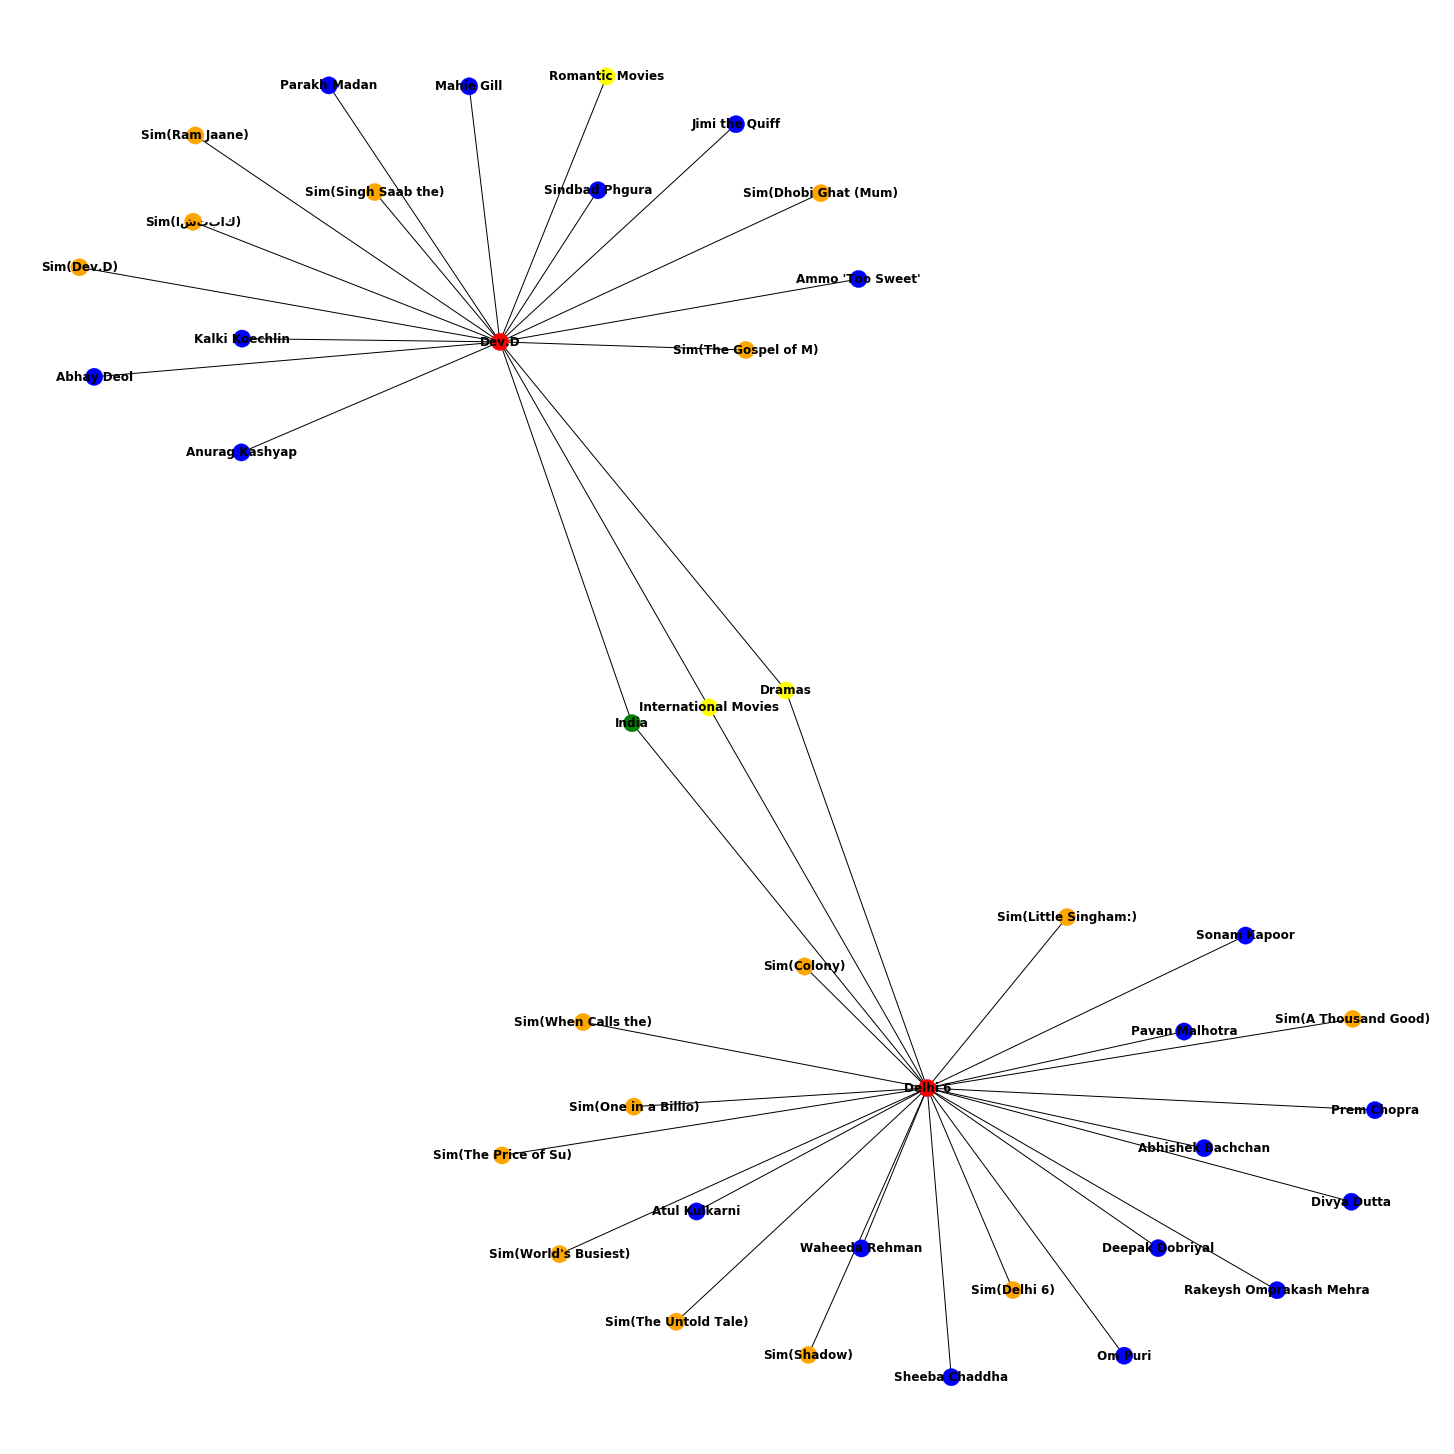

In [64]:
list_in=["Delhi 6","Dev.D"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

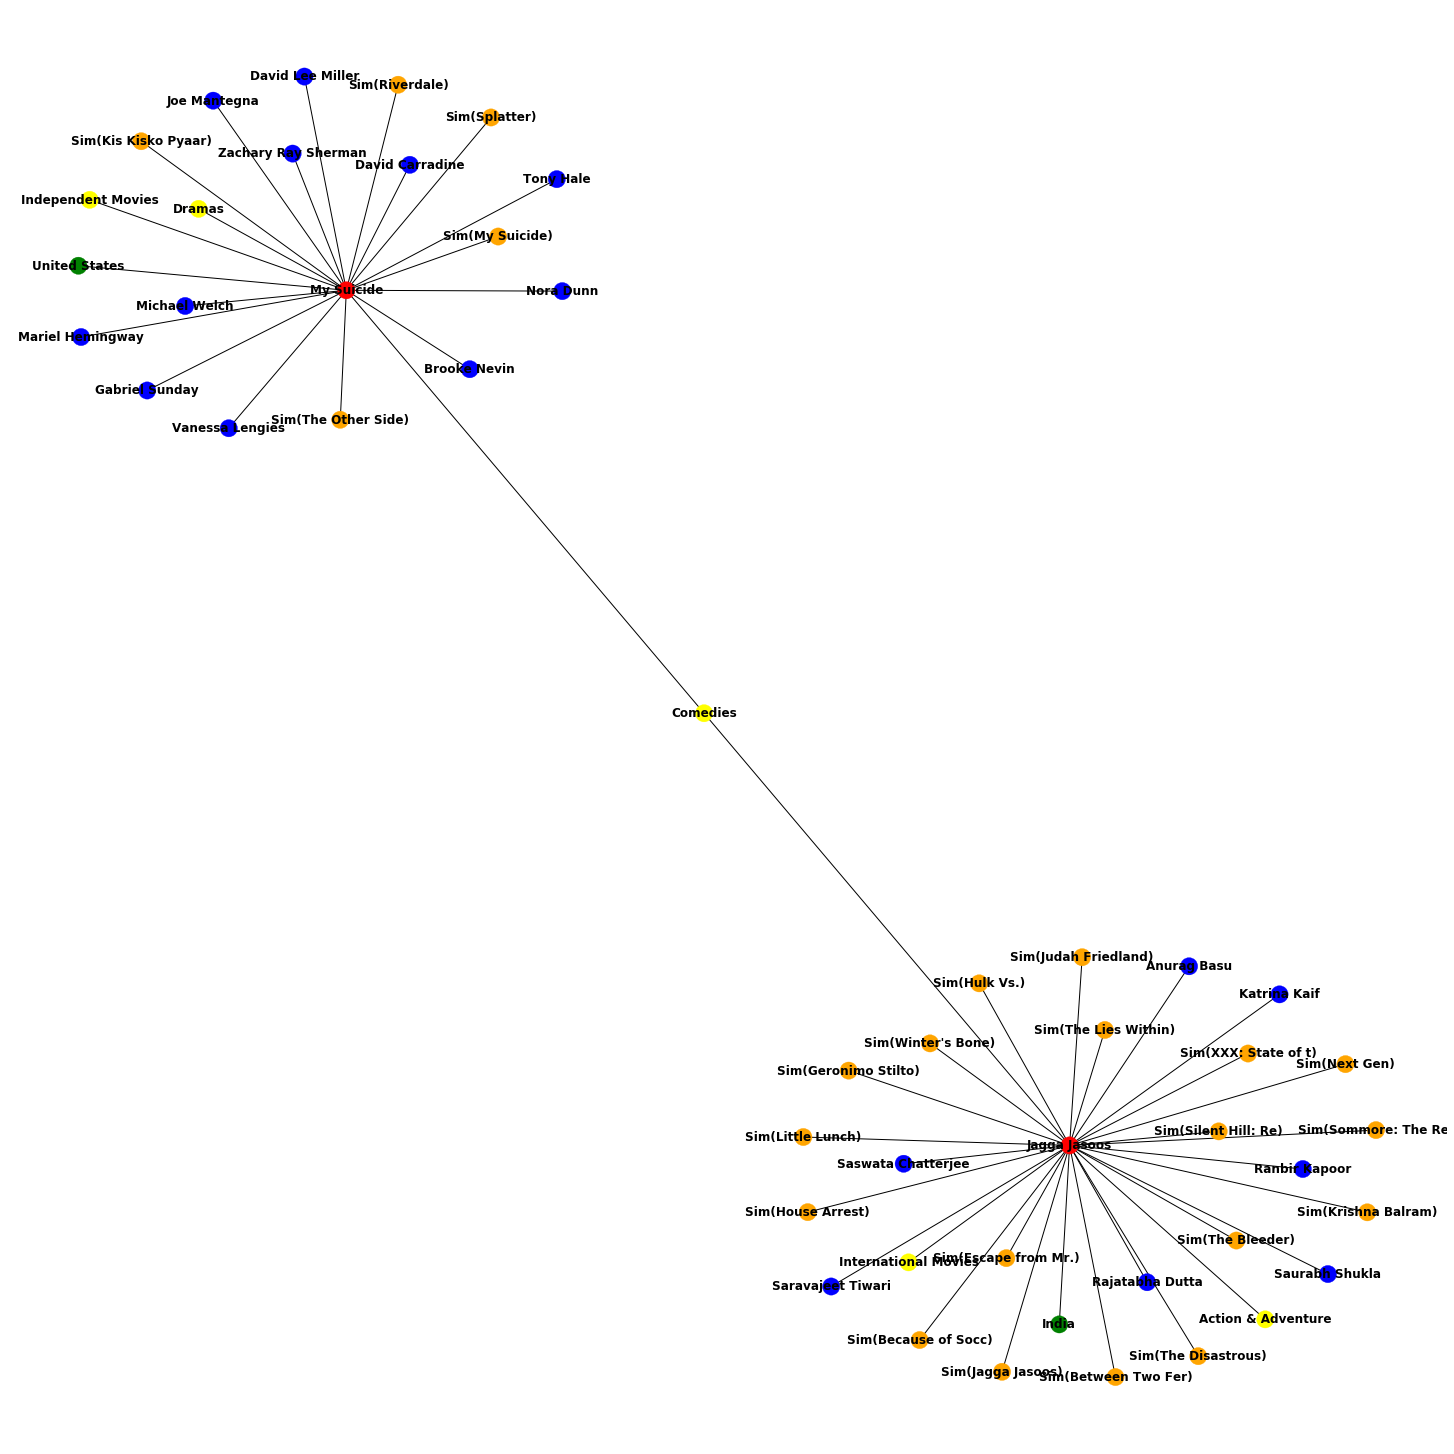

In [63]:
list_in=["My Suicide","Jagga Jasoos"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

In [51]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;


In [52]:
result = get_recommendation("Patiala House")
result2 = get_recommendation("Bhool Bhulaiyaa")

In [53]:

print("\n Recommendation for 'Patiala House'\n")
print(result.head(10))
print("\n Recommendation for 'Bhool Bhulaiyaa\n")
print(result2.head(10))



 Recommendation for 'Patiala House'

Katti Batti                                 1.859032
Bobby                                       1.833253
Super Monsters and the Wish Star            1.674332
Jaan-E-Mann: Let's Fall in Love... Again    1.633504
Sanju                                       1.595783
Mahi Way                                    1.591367
Hattrick                                    1.532558
The Sinking Of Van Der Wijck                1.383887
Kuppivala                                   1.383887
Luck by Chance                              1.352355
dtype: float64

 Recommendation for 'Bhool Bhulaiyaa

Bhagam Bhag                            2.195199
Billu                                  2.115416
Ek Hasina Thi                          2.026501
Chup Chup Ke                           1.654385
Hazaaron Khwaishein Aisi               1.326576
Life in a ... Metro                    1.326576
Honeymoon Travels Pvt. Ltd.            1.326576
Guru                                   1.2

In [54]:
result3 = get_recommendation("Delhi 6")
result4 = get_recommendation("Dev.D")

In [55]:
print("\n Recommendation for Delhi 6\n")
print(result3.head(10))
print("\n Recommendation for Dev.D\n")
print(result4.head(10))



 Recommendation for Delhi 6

Rang De Basanti         2.785631
Mirzya                  1.441098
Pranaam                 1.408742
The Price of Success    1.383887
Raees                   1.364530
Shadow                  1.242809
Namak Halaal            1.191194
Players                 1.191194
Alibaba Aur 40 Chor     1.178885
Yuva                    1.174870
dtype: float64

 Recommendation for Dev.D

The Gospel of Matthew          1.765502
Ram Jaane                      1.532558
Dhobi Ghat (Mumbai Diaries)    1.532558
Singh Saab the Great           1.532558
Zindagi Na Milegi Dobara       1.288489
Shanghai                       1.288489
Paan Singh Tomar               1.037672
Michael                        1.037672
Dil Vil Pyaar Vyaar            1.007787
Ahista Ahista                  1.002091
dtype: float64


In [56]:
result5 = get_recommendation("Earth's Natural Wonders")
result6 = get_recommendation("Islands of the Future")

In [57]:
print("\n Recommendation for Earth's Natural Wonders\n")
print(result5.head(10))
print("\n Recommendation for Islands of the Future\n")
print(result6.head(10))



 Recommendation for Earth's Natural Wonders

Earth's Natural Wonders: Life at the Extremes    2.732047
72 Cutest Animals                                1.986752
You vs. Wild                                     1.809170
Planet Earth II                                  1.772151
SuperNature: Wild Flyers                         1.317031
The 100                                          1.116221
Frozen Planet                                    1.079201
Africa                                           1.079201
Gargantia on the Verdurous Planet                1.013230
The Search for Life in Space                     1.013230
dtype: float64

 Recommendation for Islands of the Future

Occupied                        1.261155
Last Breath                     0.714436
The Darkest Dawn                0.714436
Earth's Natural Wonders         0.571736
Top 10 Secrets and Mysteries    0.571736
India: Nature's Wonderland      0.571736
Wild Arabia                     0.571736
Wild Alaska                 

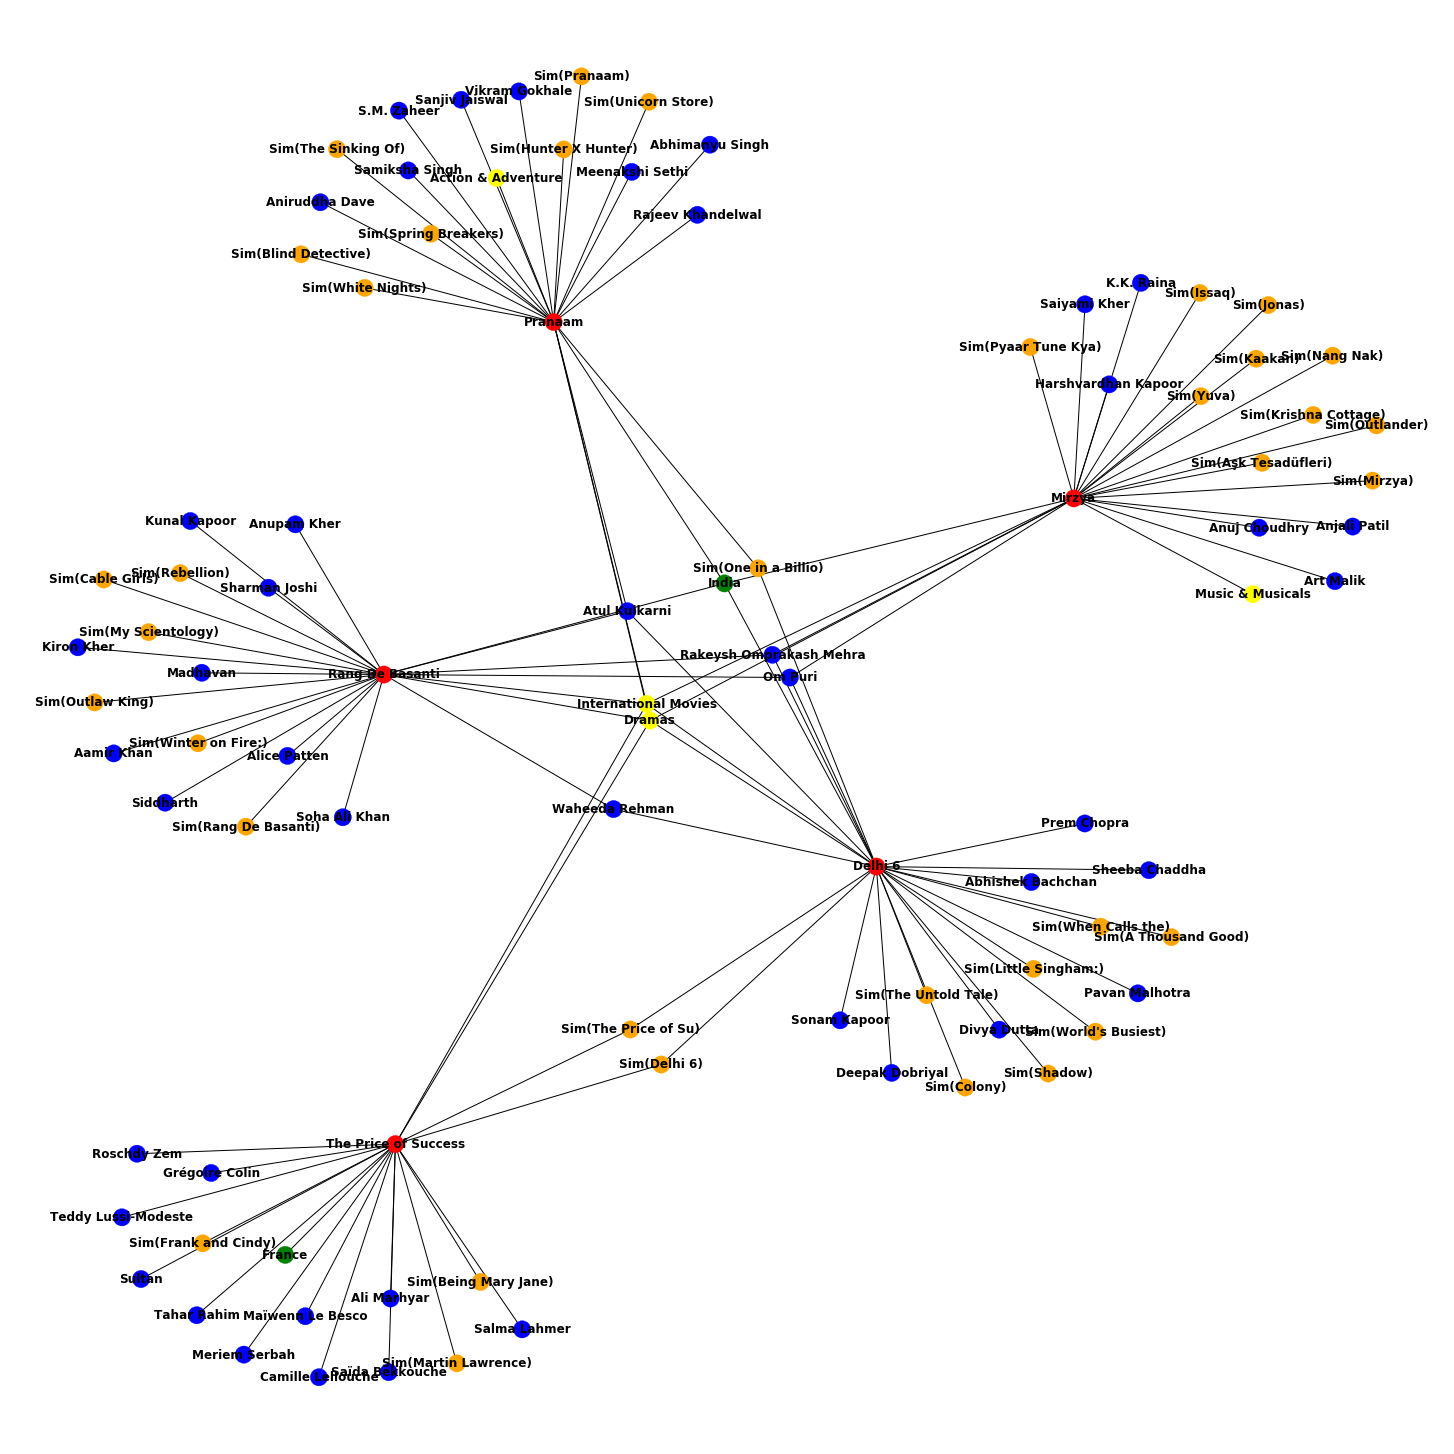

In [61]:
reco=list(result3.index[:4].values)
reco.extend(["Delhi 6"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

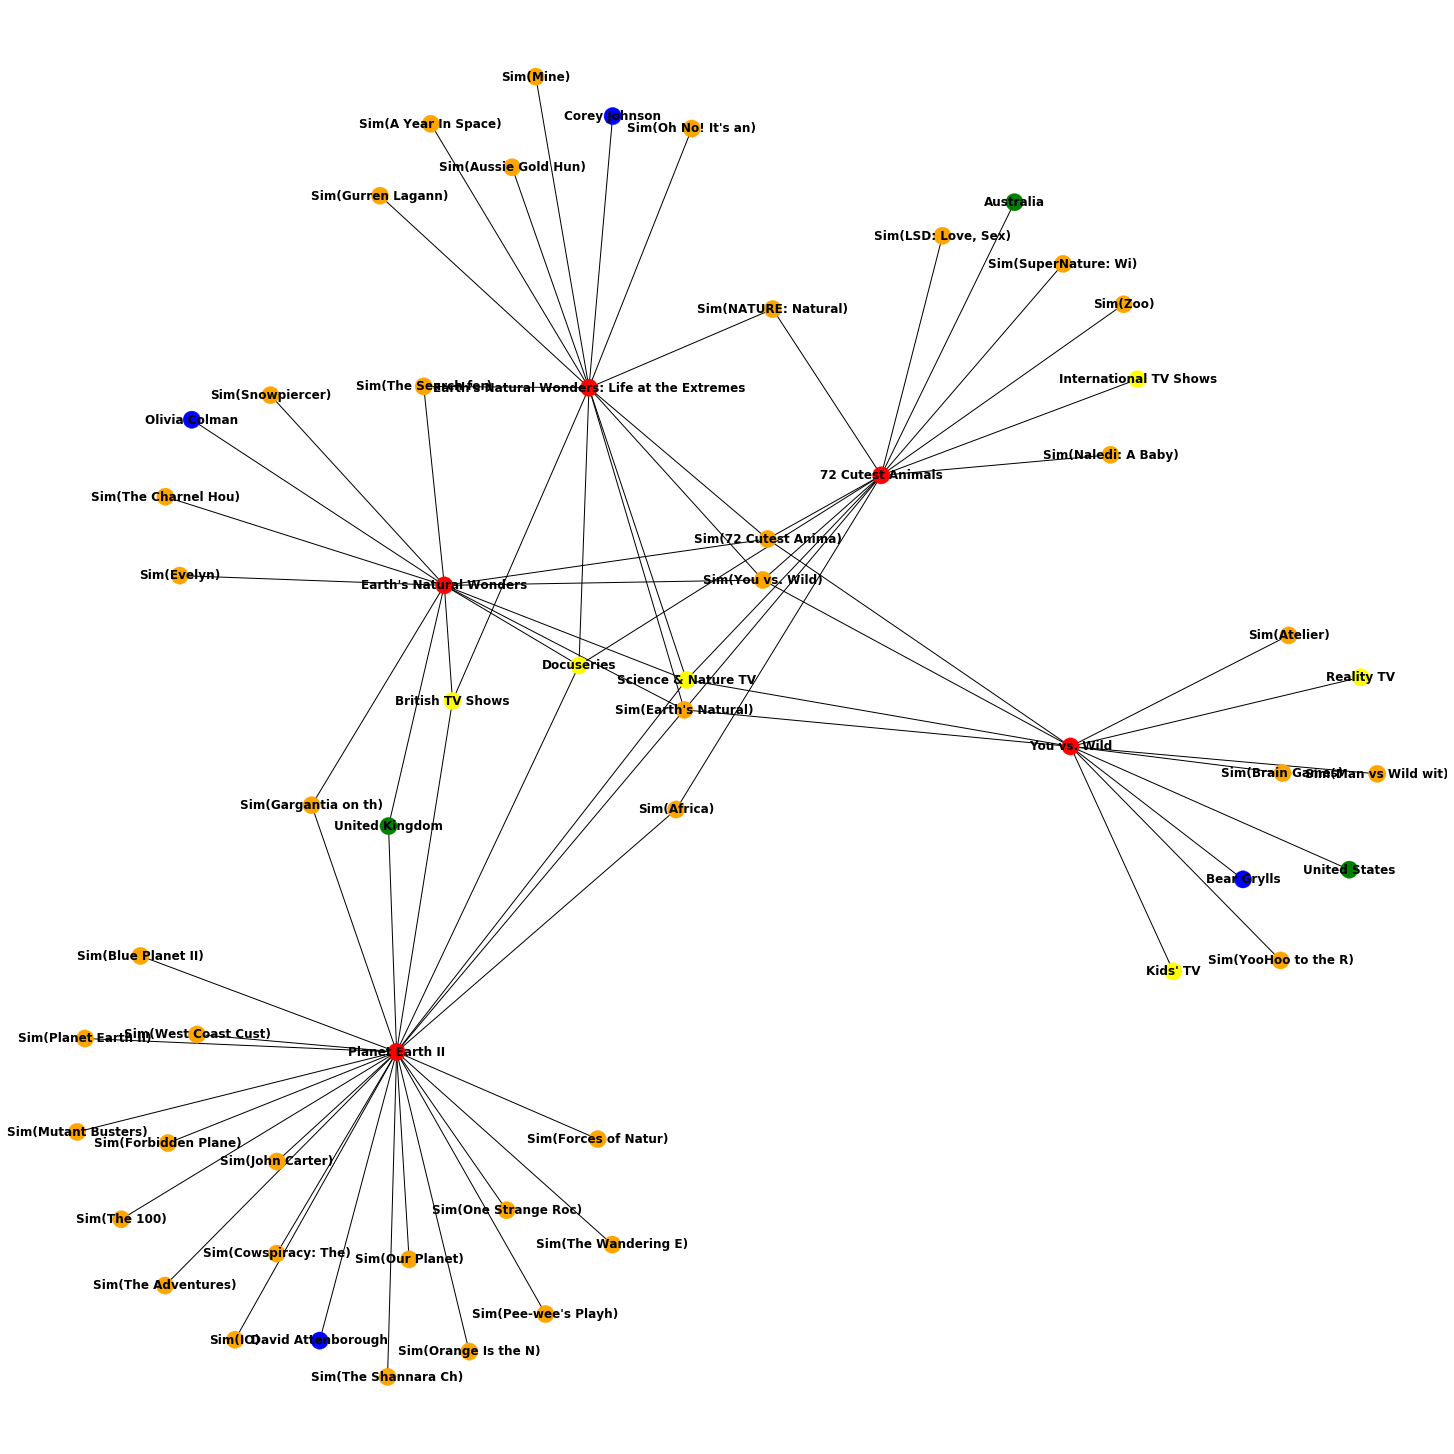

In [62]:
reco=list(result5.index[:4].values)
reco.extend(["Earth's Natural Wonders"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)